python ./LOO_nested_CV_train_skf.py mamba skf_v0 mdd_classification_mamba

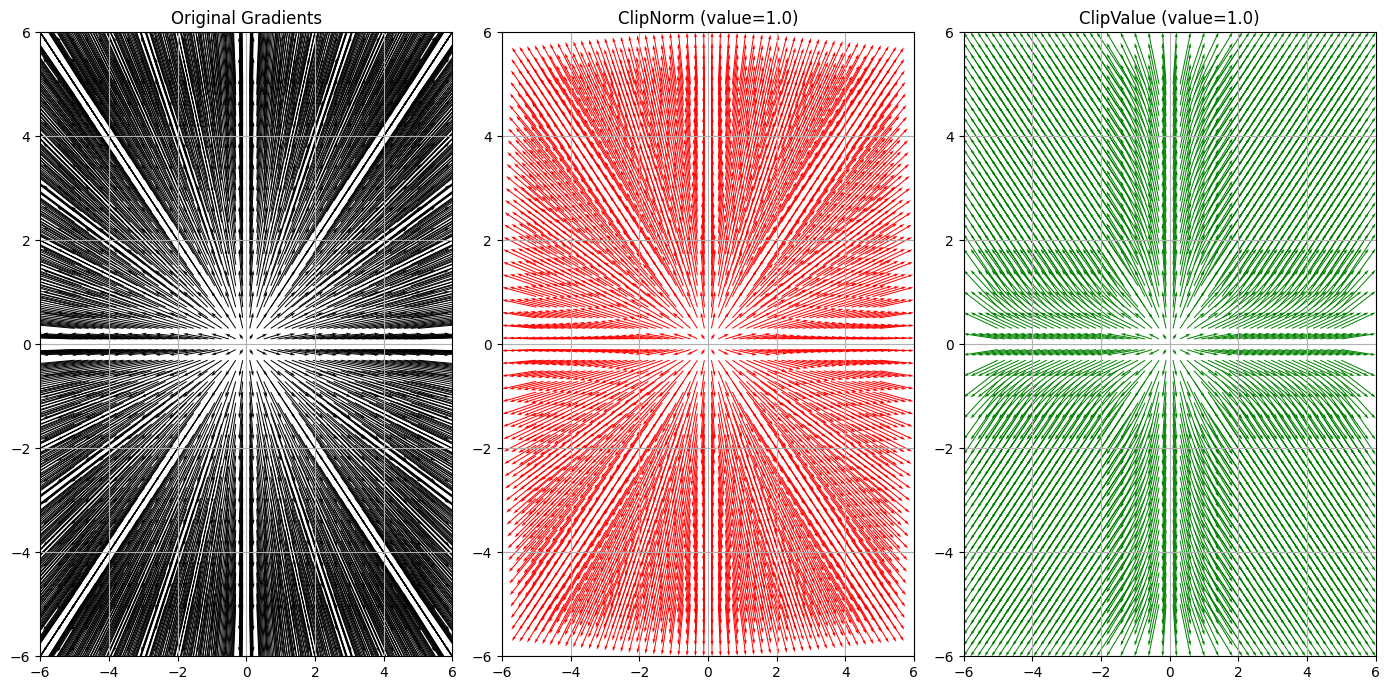

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the clipnorm function
def apply_clipnorm(g, clipnorm):
    norm = np.linalg.norm(g)
    if norm > clipnorm:
        g = g * (clipnorm / norm)
    return g

# Define the clipvalue function
def apply_clipvalue(g, clipvalue):
    g = np.clip(g, -clipvalue, clipvalue)
    return g

# Create a set of gradient vectors (2-dimensional for visualization purposes)
gradient_vectors = np.array([[x, y] for x in np.linspace(-5, 5, 50) for y in np.linspace(-5, 5, 50)])

# Apply clipnorm and clipvalue
clipnorm_value = 1.0
clipvalue_value = 1.0

# Clip gradients using clipnorm
clipnorm_g = np.array([apply_clipnorm(gi, clipnorm_value) for gi in gradient_vectors])

# Clip gradients using clipvalue
clipvalue_g = np.array([apply_clipvalue(gi, clipvalue_value) for gi in gradient_vectors])

# Plot the results
plt.figure(figsize=(14, 7))

# Original gradients
plt.subplot(1, 3, 1)
plt.quiver(gradient_vectors[:, 0], gradient_vectors[:, 1], gradient_vectors[:, 0], gradient_vectors[:, 1], angles='xy', scale_units='xy', scale=1)
plt.title('Original Gradients')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(True)

# ClipNorm results
plt.subplot(1, 3, 2)
plt.quiver(gradient_vectors[:, 0], gradient_vectors[:, 1], clipnorm_g[:, 0], clipnorm_g[:, 1], angles='xy', scale_units='xy', scale=1, color='r')
plt.title(f'ClipNorm (value={clipnorm_value})')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(True)

# ClipValue results
plt.subplot(1, 3, 3)
plt.quiver(gradient_vectors[:, 0], gradient_vectors[:, 1], clipvalue_g[:, 0], clipvalue_g[:, 1], angles='xy', scale_units='xy', scale=1, color='g')
plt.title(f'ClipValue (value={clipvalue_value})')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(True)

plt.tight_layout()
plt.show()


In [1]:
# Define the metrics dictionary
metrics = {
    'gender': 'accuracy', 
    'age': 'accuracy', 
    'education': 'accuracy', 
    'smoking': 'accuracy', 
    'alcohol': 'accuracy',
    'HAMD_Scores': 'accuracy',
    'Suicide_Risk': 'accuracy', 
    'depression': 'accuracy'
}

for i, key in enumerate(metrics):
    print(i, key)

0 gender
1 age
2 education
3 smoking
4 alcohol
5 HAMD_Scores
6 Suicide_Risk
7 depression


In [75]:
feature_pth = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/diagnosis514/extracted_featues.npy'
label_pth = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/diagnosis514/label.npy'

feature = np.load(feature_pth)
label = np.load(label_pth)


def normalize_along_features(data):
    """ 
    Args: 
        data: numpy array of shape (num_samples, num_features)
        
    Returns:
        data: numpy array of shape (num_samples, num_features)
    """

    norm_mean = np.mean(data, axis=0)
    norm_std = np.std(data, axis=0)
    norm_data = (data - norm_mean) / norm_std
    return norm_data

normalized_feature = normalize_along_features(feature)

HC = normalized_feature[label == 0]
MDD = normalized_feature[label == 1]
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection


# Perform t-tests for each feature
t_stat, p_values = ttest_ind(HC, MDD, axis=0)

# Apply FDR correction
rejected, p_values_corrected = fdrcorrection(p_values)

# Define significance level
significance_level = 0.0005

# Find significant features
significant_features = np.where((rejected) & (p_values_corrected < significance_level))[0]

print("Significant features after FDR correction:")
print(len(significant_features), significant_features)
print("Corrected p-values for significant features:")
print(p_values_corrected[significant_features])



Significant features after FDR correction:
21 [1054 1055 1056 1164 1189 1190 1191 1207 1208 1324 1325 1326 1327 1342
 1343 1351 1352 1353 1354 1369 1371]
Corrected p-values for significant features:
[1.04662119e-05 1.84472741e-04 4.15500684e-05 3.17492773e-04
 9.81120197e-06 1.04662119e-05 5.00378597e-05 6.39301295e-05
 8.44181111e-05 2.68120657e-09 2.30543672e-06 9.81120197e-06
 1.52429017e-04 7.58914597e-07 1.84472741e-04 2.30543672e-06
 7.21742159e-06 3.93971006e-06 7.16242867e-05 1.52429017e-04
 3.94293942e-04]


In [76]:
np.save('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/diagnosis514/sig_normalized_feature.npy', normalized_feature[:, significant_features])

In [80]:
data = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/diagnosis514/hamd.npy')
len(data.shape)

1

: 

In [1]:
import sys
import time
from datetime import date
import numpy as np
import random
import wandb
import gc
from classifiers.classifier_factory import create_classifier
from scripts.plot.DL.read_LOO_nestedCV_gnntr import get_sorted_loo_array
import subprocess
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 

from utils.utils_mine import normalize_individual


2024-06-30 14:31:51.458078: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 14:31:51.476997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 14:31:51.477020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 14:31:51.477027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 14:31:51.481775: I tensorflow/core/platform/cpu_feature_g

In [2]:
import numpy as np 
from scipy.io import loadmat
import sys 
import os

def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
    else:
        print("Current system is neither macOS nor Ubuntu")
    os.chdir(main_fold_path)
    sys.path.append(main_fold_path)    

set_path()

def delete_fnirs_features(folders):
    filename = 'fnirs_features.npy'
    
    for folder in folders:
        # Construct full path to fnirs_features.npy within current folder
        filepath = os.path.join(folder, filename)
        
        # Check if file exists and delete it if so
        if os.path.exists(filepath):
            try:
                os.remove(filepath)
                print(f"Deleted {filepath}")
            except Exception as e:
                print(f"Error deleting {filepath}: {e}")
        else:
            print(f"{filename} not found in {folder}")

if __name__ == "__main__":
    # Input folders separated by commas (or any other delimiter you prefer)
    # input_folders = input("Enter folder paths separated by commas: ")
    
    # Split input string into list of folders; strip whitespace around each entry
    folders_list = ['diagnosis_110_fabeha_dataset_hb_all',
                    'diagnosis_250_fabeha_dataset_hb_all',
                    'diagnosis514',
                   ]#[folder.strip() for folder in input_folders.split(',')]
    
    # Call function with list of folders
    delete_fnirs_features(folders_list)

fnirs_features.npy not found in diagnosis_110_fabeha_dataset_hb_all
fnirs_features.npy not found in diagnosis_250_fabeha_dataset_hb_all
fnirs_features.npy not found in diagnosis514


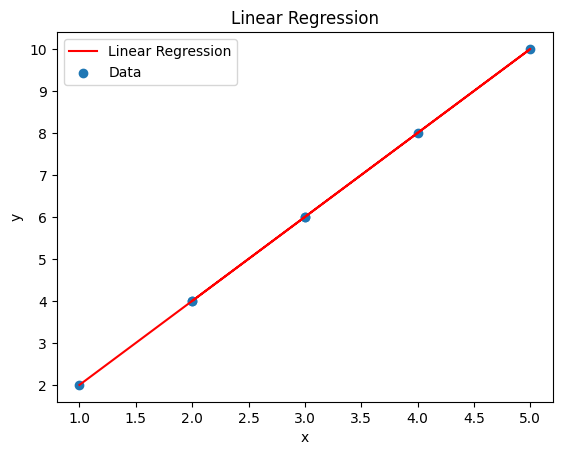

In [7]:
import numpy as np

import matplotlib.pyplot as plt


# Define the x and y data
x = np.array([1, 2, 3, 4, 5, 3, 2])
y = np.array([2, 4, 6, 8, 10, 6, 4])

# Perform linear regression
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the regression line
regression_line = slope * x + intercept

# Plot the data and regression line
plt.scatter(x, y, label='Data')
plt.plot(x, regression_line, color='red', label='Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()

In [3]:
np.load('allData/diagnosis_110_fabeha_dataset_hb_all/nor_hb_simple_all_1d.npy').mean()

-5.035081390934044e-19

In [6]:
hb_data = np.load('allData/prognosis_mix_hb/pretreatment_response/hb_data.npy')
hb_data.shape
hb_data = normalize_individual(hb_data)
np.save('allData/prognosis_mix_hb/pretreatment_response/nor_hb_data.npy', hb_data)

: 

In [29]:
from utils.utils_mine import generate_fnirs_adj_tf

In [44]:
import tensorflow as tf

# Define the adjacency matrix and input features
dm_1 = np.zeros((1, 52))
dm_1[0, 1] = 1
dm_1[0, 2] = 1
dm1 = tf.convert_to_tensor(dm_1, dtype=tf.float32)
adj = tf.ones((51, 52))
adj = tf.concat([dm1, adj], axis=0)
inputs_features = tf.ones((10, 52, 125))

# Perform matrix multiplication
result = tf.linalg.matmul(adj, inputs_features)

# Print the result shape
print("Result shape:", result.shape)


Result shape: (10, 52, 125)


In [46]:
result[0]

<tf.Tensor: shape=(52, 125), dtype=float32, numpy=
array([[ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [52., 52., 52., ..., 52., 52., 52.],
       [52., 52., 52., ..., 52., 52., 52.],
       ...,
       [52., 52., 52., ..., 52., 52., 52.],
       [52., 52., 52., ..., 52., 52., 52.],
       [52., 52., 52., ..., 52., 52., 52.]], dtype=float32)>

: 

In [31]:
# a = generate_fnirs_adj()
# a = a.toarray()
tf_matrix = generate_fnirs_adj_tf()
tf_matrix

<tf.Tensor: shape=(52, 52), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

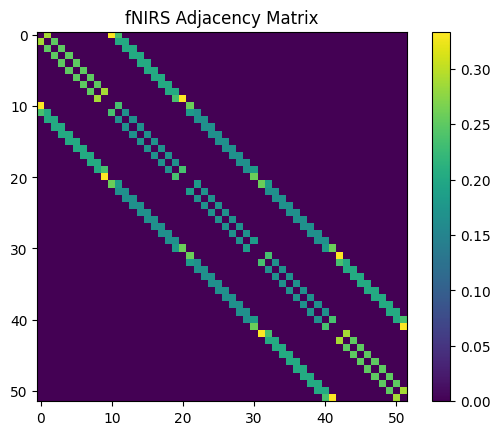

In [34]:

def normalize_adjacency(adj):
    d = tf.reduce_sum(adj, axis=-1)
    d_sqrt_inv = tf.pow(d, -0.5)
    d_sqrt_inv = tf.where(tf.math.is_inf(d_sqrt_inv), 0., d_sqrt_inv)
    d_mat_inv_sqrt = tf.linalg.diag(d_sqrt_inv)
    return tf.matmul(tf.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

nor_m = normalize_adjacency(tf_matrix)

plt.imshow(nor_m, cmap='viridis')
plt.colorbar()
plt.title('fNIRS Adjacency Matrix')
plt.show()

In [27]:
adj_matrix_tf = generate_fnirs_adj_tf()
adj_matrix_tf 
# adj_matrix_tf = np.tile(adj_matrix_tf, (512, 1, 1))

# adj_matrix_tf.shape
# # Plot the matrix using imshow
# plt.imshow(adj_matrix_tf[1], cmap='viridis')
# plt.colorbar()
# plt.title('fNIRS Adjacency Matrix')
# plt.show()

<tf.Tensor: shape=(52, 52), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [6]:
adj = np.load('allData/diagnosis458/adj_matrix.npy')[:1, ...]
new_adj = np.tile(adj, (514, 1, 1))
np.save('allData/diagnosis514/adj_matrix.npy', new_adj)

In [12]:
np.round(np.random.randint(0, 1000), 4)

737

In [7]:
data_path = 'allData/diagnosis514/hb_data.npy'

data = np.load(data_path)
from scipy.stats import zscore
data = zscore(data, axis=1)
print(data.shape)
print(np.mean(data))
# print(np.mean(data, axis=0))
# print(data.shape)
# if data.shape[1] != 52:
#     print(data.shape)
#     data = np.transpose(data, (0, 2, 1))
np.save(data_path, data)

(458, 52, 125)
-1.2411226825503933e-18


In [10]:
TOTAL_SUBJECT = 64
TOTAL_FOLD = 5
delete_name = ['fold-best-checkpoint.data-00000-of-00001', 'fold-best-checkpoint.index', 'history.csv']
for subject_id in range(TOTAL_SUBJECT):
    for fold_id in range(TOTAL_FOLD):
        path = f'results/mamba/prognosis_mix_hb/pretreatment_response/loocv_v0pretreatment_response_mamba/LOO_nested_CV/LOO_{subject_id}/stratified_nested_5_CV_fold-{fold_id}/'
        file_names = os.listdir(path)
        for delete_path in [path + file_name for file_name in file_names if file_name in delete_name]:
            os.remove(delete_path)
        
        

In [14]:

# Define the tensor dA
dA = tf.constant([
    [
        [[1, 2], [3, 4], [5, 6]],
        [[7, 8], [9, 10], [11, 12]],
        [[13, 14], [15, 16], [17, 18]]
    ],
    [
        [[19, 20], [21, 22], [23, 24]],
        [[25, 26], [27, 28], [29, 30]],
        [[31, 32], [33, 34], [35, 36]]
    ]
], dtype=tf.float32)  # Shape [2, 3, 3, 2]

# Slice and pad the tensor
dA_cumsum = tf.pad(
    dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, :, :, :]

# print(dA_cumsum)
# dA_cumsum = tf.reverse(dA_cumsum, axis=[0]) 
# print(dA_cumsum)

# dA_cumsum = tf.math.cumsum(dA_cumsum, axis=1)  

print(dA_cumsum)


tf.Tensor(
[[[[ 0.  0.]
   [ 0.  0.]
   [ 0.  0.]]

  [[ 7.  8.]
   [ 9. 10.]
   [11. 12.]]

  [[13. 14.]
   [15. 16.]
   [17. 18.]]

  [[ 0.  0.]
   [ 0.  0.]
   [ 0.  0.]]]


 [[[ 0.  0.]
   [ 0.  0.]
   [ 0.  0.]]

  [[25. 26.]
   [27. 28.]
   [29. 30.]]

  [[31. 32.]
   [33. 34.]
   [35. 36.]]

  [[ 0.  0.]
   [ 0.  0.]
   [ 0.  0.]]]], shape=(2, 4, 3, 2), dtype=float32)


: 

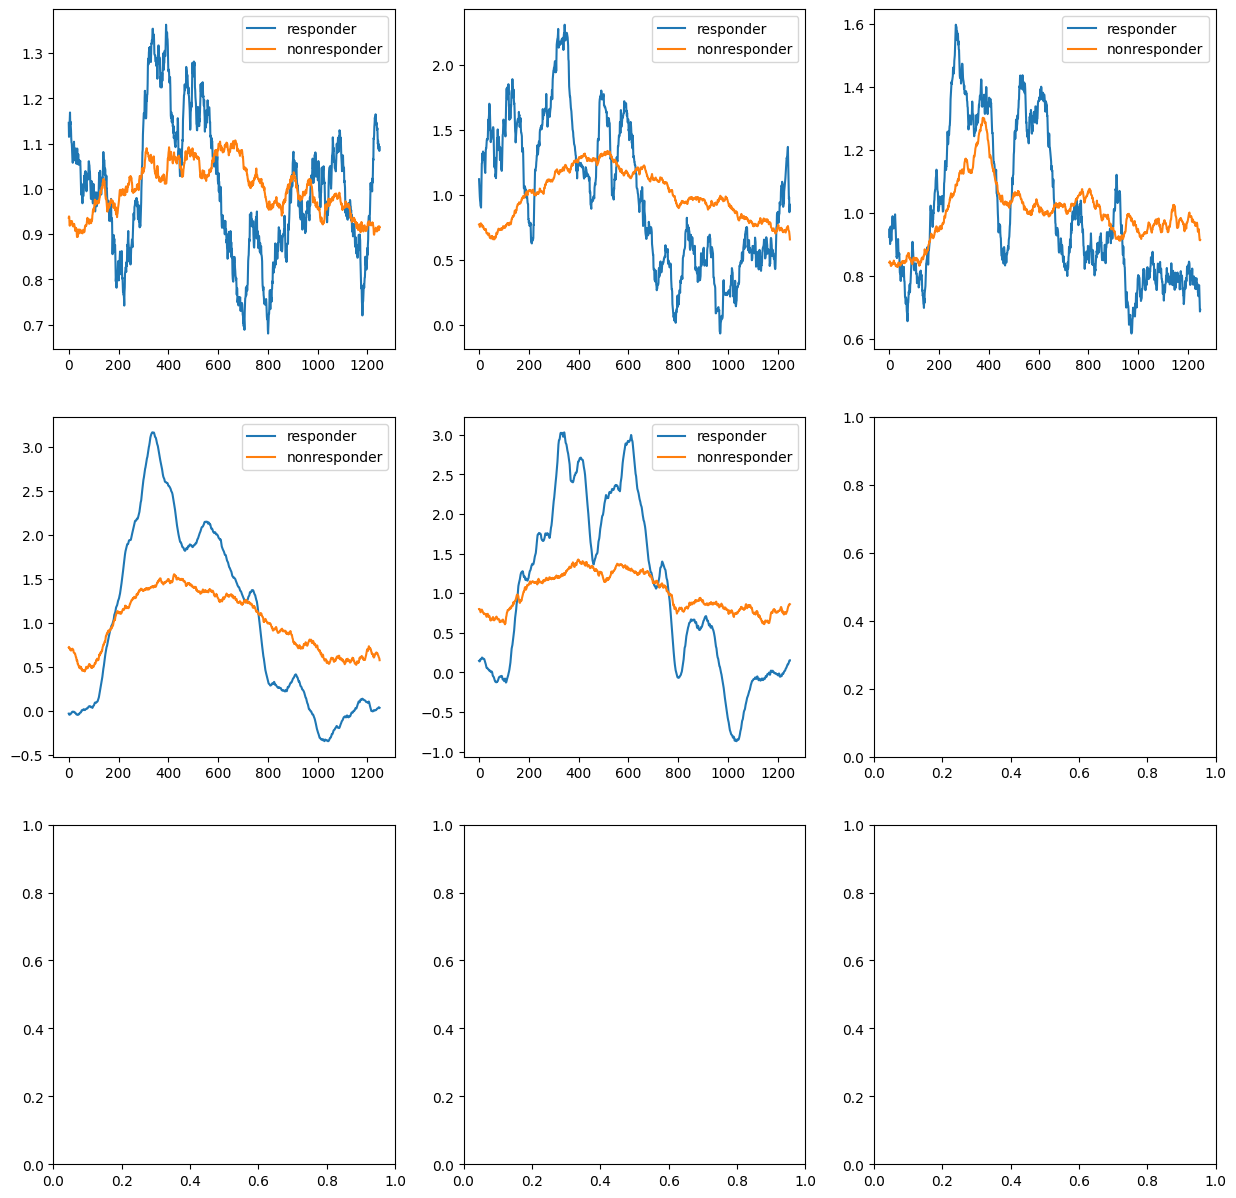

In [5]:
data = np.load('allData/prognosis_mix_hb/pretreatment_response/task_change_hb_nine_regions.npy')
HbT = data[..., -1]
print(HbT.shape)
np.save('allData/prognosis_mix_hb/pretreatment_response/task_change_hb_nine_regions_HbT.npy', HbT)

(64, 9)


In [3]:
import torch
import torch.nn as nn
torch.einsum("subscripts", operands)



NameError: name 'operands' is not defined

In [24]:
# data = pd.read_csv('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/ML_results/simple_prediction_response/clinical_data_modality_classification/Discriminant Analysis(LDA).csv')
# data.iloc[60:]
# data.to_csv('./LDA_results.csv')



#  result_pth = main_fold + modality + '/' + model + '_pred.json'
#         with open(result_pth, 'r') as json_file:
#             data = json.load(json_file)
#             auc_result[model][modality] = data

print(modality, model_name, df.shape)

tmp = df.iloc[:,60:]
tmp.to_json('./LDA_results.json')
print(tmp.shape)



/clinical_data_modality_classification/ SVM (3, 99)
(3, 39)


In [26]:
# data_pth = 'allData/prognosis_mix_hb/pretreatment_response/nor_demo_cli_merge_data.npy'
# data = np.load(data_pth, allow_pickle=True)
# print(data.shape)

# delete the first 60 elements of clinical and clinical_fnirs json and csv
main_fold = 'results/ML_results/simple_prediction_response'
modalities = ['/clinical_data_and_fnirs_modality_classification/', '/clinical_data_modality_classification/']
models_name = ['Naive Bayes', 'Discriminant Analysis(LDA)', 'Random Forest', 'SGDClassifier', 'XGBoost', 'SVM']

for modality in modalities:
    for model_name in models_name:
        result_pth = main_fold + modality + '/' + model_name + '.csv'
        
        df = pd.read_csv(result_pth)
        df = df.iloc[60:]
        # df.to_csv(result_pth, index=False)
        
        detail_pth = main_fold + modality + '/' + model_name + '_pred.json'
        df = pd.read_json(detail_pth)
        df = df.iloc[:, 60:]
        # df.to_json(detail_pth, orient='records', lines=True)
        # print(modality, model_name, df.shape)
        # print('---')

ValueError: Trailing data

: 

In [2]:
from PIL import Image

# Open the image
img = Image.open('/Users/shanxiafeng/Desktop/brain.png')

# Convert the image to RGBA (if not already in that mode)
img = img.convert("RGBA")

# Get the data of the image
data = img.getdata()

# Create a new list for the new data
new_data = []

# Define the background color you want to make transparent
background_color = (255, 255, 255, 255)  # White background

# Loop through the data and change the background color to transparent
for item in data:
    if item[:3] == background_color[:3]:  # Check RGB value (ignore alpha)
        new_data.append((255, 255, 255, 0))  # Change to transparent
    else:
        new_data.append(item)  # Keep original color

# Update image data
img.putdata(new_data)

# Save the image with a new name
img.save('FigureTable/manuscript_figures/fig1_brain_image_transparent.png', 'PNG')

In [1]:
import numpy as np
from scipy.stats import binom_test
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import norm

# 假设模型的真实标签和预测标签
true_labels = np.array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])
pred_labels = np.array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

# 计算平衡准确度
bAcc = balanced_accuracy_score(true_labels, pred_labels)
print(f'Balanced Accuracy: {bAcc}')

# 独特测试样本数量
n_samples = len(true_labels)

# 计算随机情况下的平衡准确度的置信区间
# 这里我们假设随机情况下的准确度为0.5
p_hat = 0.5

# 计算标准误
standard_error = np.sqrt(p_hat * (1 - p_hat) / n_samples)

# 95% 置信区间
z_score = norm.ppf(0.975)  # 对于95%的置信区间
ci_lower = p_hat - z_score * standard_error
ci_upper = p_hat + z_score * standard_error
print(f'95% Confidence Interval for Random Balanced Accuracy: ({ci_lower}, {ci_upper})')

# 使用单尾二项检验检验模型的性能是否显著优于随机
successes = sum(pred_labels == true_labels)
p_value = binom_test(successes, n_samples, p=p_hat, alternative='greater')
print(f'One-tailed Binomial Test p-value: {p_value}')

Balanced Accuracy: 0.90625
95% Confidence Interval for Random Balanced Accuracy: (0.3267620219562902, 0.6732379780437098)
One-tailed Binomial Test p-value: 1.2780074030160904e-06


: 

In [6]:
# for i in range(95, 100):
mean_df = pd.DataFrame()

'results/ML_results/ssimple_prediction_partial_response/fnirs_modality_classification/Naive Bayes0_1.csv'

for i in [i/100 for i in range (51, 60)]:#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]: #[0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]+ [0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29]: #
    i = str(i).replace('.', '_')
    # results/ML_results/simple_prediction_partial_response/fnirs_modality_classification/Naive Bayes0_5.csv
    # main_path = 'results/ML_results/ssimple_prediction_partial_response/fnirs_modality_classification/Naive Bayes{}.csv'.format(i)# 'results/ML_results/simple_prediction/fnirs_modality_classification/Naive Bayes_{}.csv'.format(i)
    main_path = 'results/ML_results/simple_prediction_partial_response/fnirs_modality_classification/SGDClassifier{}.csv'.format(i)
    df = pd.read_csv(main_path)
    df_mean = df.mean()
    mean_df = mean_df.append(df_mean, ignore_index=True)
print(mean_df)    
    
    

# # delete low validation_sensitivity row
# main_path = 'results/ML_results/simple_prediction/fnirs_modality_classification/Discriminant Analysis(QDA).csv'# 'results/ML_results/simple_prediction/fnirs_modality_classification/Naive Bayes_{}.csv'.format(i)
# df = pd.read_csv(main_path)
# # Filter out rows where validation_sen is less than 0.5
# df_cleaned = df[df['validation_sen'] >= 0.5]
# # Save the cleaned DataFrame back to the CSV file
# df_cleaned.to_csv(main_path, index=False)
# # df_mean = df.mean()
# # mean_df = mean_df.append(df_mean, ignore_index=True)
# print(mean_df)    

    random_seed  test_acc  test_auc  test_sen  test_spe  validation_acc  \
0  1.716885e+09  0.349340  0.292868  0.410900  0.287744        0.510728   
1  1.716885e+09  0.458960  0.440984  0.452108  0.465812        0.514532   
2  1.716885e+09  0.494372  0.477648  0.454536  0.534192        0.518772   
3  1.716885e+09  0.491788  0.461704  0.414536  0.569020        0.515196   
4  1.716885e+09  0.512576  0.505028  0.430284  0.594836        0.525200   
5  1.716885e+09  0.502624  0.491852  0.358760  0.646448        0.514792   
6  1.716885e+09  0.502404  0.505136  0.385432  0.619356        0.511696   
7  1.716885e+09  0.522044  0.517472  0.436332  0.607736        0.523400   
8  1.716885e+09  0.531876  0.522300  0.372084  0.691608        0.526756   

   validation_auc  validation_sen  validation_spe  
0        0.518668        0.584296        0.437160  
1        0.536748        0.507520        0.521540  
2        0.551212        0.488680        0.548864  
3        0.544628        0.452772        

: 

results/ML_results/simple_prediction/fnirs_modality_classification/SGDClassifier0_21_pred.csv
results/ML_results/simple_prediction/fnirs_modality_classification/SGDClassifier0_21.csv

In [22]:
df = pd.read_csv("results/ML_results/simple_prediction/fnirs_modality_classification/SVM.csv")
total_rows = len(df)
selected_arr = [i for i in range(total_rows) if i % 3 == 0]
filter_df = df.iloc[selected_arr]
filter_df
main_fold = 'results/ML_results/simple_prediction/'
modalities = ['fnirs_modality_classification', 'clinical_data_and_fnirs_modality_classification']
models = ['KNN', 'MLP', 'Naive Bayes', 'Random Forest', 'SVM', 'XGBoost']
for modality in modalities:
    for model in models:
        pth = main_fold + modality + '/' + model + '.csv'
        df = pd.read_csv(pth)
        total_rows = len(df)
        selected_arr1 = [i for i in range(13)]
        selected_arr2 = [i for i in range(13, total_rows) if i % 3 == 0]
        selected_arr = selected_arr1 + selected_arr2
        filter_df = df.iloc[selected_arr]
        print(filter_df)
        filter_df.to_csv(pth, index=False)
    #     break
    # break
        # new_rows = len(filter_df)
        # selected_rows.to_csv(, index=False)

    random_seed  validation_acc  validation_sen  validation_spe  \
0    1716702205          0.6609          0.4573          0.8645   
1    1716702206          0.6151          0.3594          0.8708   
2    1716702967          0.6552          0.4557          0.8546   
3    1716702968          0.6335          0.3266          0.9405   
4    1716703811          0.6455          0.4115          0.8795   
5    1716703812          0.6597          0.4589          0.8606   
6    1716704542          0.6224          0.3812          0.8635   
7    1716704543          0.6507          0.4573          0.8441   
8    1716705398          0.6270          0.3995          0.8546   
9    1716705399          0.6200          0.3875          0.8524   
10   1716706166          0.6286          0.4078          0.8493   
11   1716706167          0.6085          0.3443          0.8728   
12   1716707656          0.5695          0.2865          0.8525   
15   1716707658          0.6643          0.4516          0.877

: 

In [22]:
from sklearn.linear_model import Perceptron
model = Perceptron(class_weight='balanced')

In [14]:
data = np.load('results/ML_results/simple_prediction/clinical_data_and_fnirs_mddr_modality_classification/ten_repeat_nested_cv.npy', allow_pickle=True)    

model_name = [i for i in data.item()[0]['inner_result']]
model_name

# headers = ["random_seed", "validation_acc", "validation_sen", "validation_spe", "validation_f1",
#            "test_acc", "test_sen", "test_spe", "test_f1"]

# save_fold = 'results/ML_results/simple_prediction/clinical_data_and_fnirs_modality_classification/'

# def save_into_csv(csv_filename, arr):
#     df = pd.DataFrame([arr], columns=headers)
#     file_exists = os.path.isfile(csv_filename)
#     if not file_exists:
#         # If file does not exist, write data with headers   
#         df.to_csv(csv_filename, index=False, mode='w')
#         print(f"Data saved to {csv_filename} with headers.")
#     else:
#         # If file exists, append data without headers
#         df.to_csv(csv_filename, index=False, mode='a', header=False)
#         print(f"Data appended to {csv_filename} without headers.")
        
# for model in model_name:
#     val_result = [val for key, val in data.item()[0]['inner_result'][model].items()]
#     test_result = [val for key, val in data.item()[0]['external_result'][model].items()]
#     val_test_arr = [42] +  val_result + test_result
    
#     save_path = save_fold + model + '.csv'
#     save_into_csv(save_path, val_test_arr)
    
    
#     print(val_test_arr)
pass

FileNotFoundError: [Errno 2] No such file or directory: 'results/ML_results/simple_prediction/clinical_data_and_fnirs_mddr_modality_classification/ten_repeat_nested_cv.npy'

In [10]:
fold = 'allData/RawData/Baseline_fnirs/Patients'
os.listdir(fold)
subject_name = [i[:5] for i in os.listdir(fold) if i[:2] == 'PT']
subject_name = list(subject_name)
subject_name = list(set(subject_name))
for name in subject_name:
    if name[-3:] == '036':
        print(name)

len(subject_name)

PT036


70

In [44]:
result = 'results/ML_results/simple_prediction/clinical_data_modality_classification/ten_repeat_nested_cv.npy'
result = np.load(result, allow_pickle=True)
result = result.item()
# for key, value in result.items():
#     print(key)
#     print(value)
#     print('--------------------------------------')
classifiers_name = list(result[0]['external_result'].keys())
metrics = list(result[0]['external_result'][classifiers_name[0]].keys())

avg_inner_result = {classifier_name: {metric: [] for metric in metrics} for classifier_name in classifiers_name}
avg_external_result = {classifier_name: {metric: [] for metric in metrics} for classifier_name in classifiers_name}


for classifier in classifiers_name:
    for metric in metrics:

        avg_inner_result[classifier][metric] = [result[i]['inner_result'][classifier][metric] for i in range(10)]
        avg_external_result[classifier][metric] = [result[i]['external_result'][classifier][metric] for i in range(10)]

print("\n## Inner Cross-Validation Performance")
print("| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |")
print("|------------|-----------------|------------------|---------------------|---------------------|")
for name, metrics in avg_inner_result.items():
    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}
    print(f"| {name} | {avg_metrics['balanced accuracy']:.4f} | {avg_metrics['sensitivity']:.4f} | {avg_metrics['specificity']:.4f} | {avg_metrics['f1 score']:.4f} |")

print("\n## Outer Cross-Validation Performance")
print("| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |")
print("|------------|-----------------|------------------|---------------------|---------------------|")
for name, metrics in avg_external_result.items():
    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}

    print(f"| {name} | {avg_metrics['balanced accuracy']:.4f} | {avg_metrics['sensitivity']:.4f} | {avg_metrics['specificity']:.4f} | {avg_metrics['f1 score']:.4f} |")
                                                    
                                                   


## Inner Cross-Validation Performance
| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |
|------------|-----------------|------------------|---------------------|---------------------|
| SVM | 0.4072 | 0.4036 | 0.4108 | 0.2267 |
| XGBoost | 0.5250 | 0.4318 | 0.6182 | 0.3032 |
| Naive Bayes | 0.4376 | 0.7052 | 0.1700 | 0.3037 |

## Outer Cross-Validation Performance
| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |
|------------|-----------------|------------------|---------------------|---------------------|
| SVM | 0.2929 | 0.2857 | 0.3000 | 0.1509 |
| XGBoost | 0.5043 | 0.4286 | 0.5800 | 0.2927 |
| Naive Bayes | 0.4843 | 0.9286 | 0.0400 | 0.3467 |


: 

In [18]:
classifiers_name

['SVM', 'XGBoost', 'Naive Bayes']

In [17]:
result[0]['inner_result']['SVM']

{'balanced accuracy': 0.4072395833333333,
 'sensitivity': 0.40364583333333326,
 'specificity': 0.4108333333333333,
 'f1 score': 0.22672896547896548}

In [13]:
[i for i in range(10) for j in range(10)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [10]:
mddr_pth = 'allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy'
label_pth = 'allData/prognosis_mix_hb/pretreatment_response/label.npy'

mddr = np.load(mddr_pth)
label = np.load(label_pth)
print(mddr.shape)

# Extract the predictions for the second output dimension
y_scores = mddr[..., 1].flatten()
y_true = label.flatten()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


(10, 64, 2)


ValueError: Found input variables with inconsistent numbers of samples: [64, 640]

In [2]:
label_pth = 'allData/prognosis_mix_hb/pretreatment_response/label.npy'
label = np.load(label_pth)
print(label)

response_pth = 'allData/prognosis_mix_hb/pretreatment_response/label_hamd.npy'
response = np.load(response_pth)
response = (response[:, 1] - response[:, 0]) / response[:, 0]
print(response)
# np.save('allData/prognosis_mix_hb/pretreatment_response/label_reduce_percentage.npy', response)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
[-0.24       -0.33333333 -0.25925926 -0.25        0.58823529  0.5
  0.13333333  0.38095238 -0.13636364 -0.19047619 -0.28571429 -0.23809524
  0.52631579 -0.06666667 -0.56521739 -0.38095238  0.         -0.44444444
 -0.4         0.26315789 -0.66666667 -0.36       -0.86363636 -0.33333333
 -0.43333333 -0.76       -0.5        -0.16666667 -0.42307692 -0.25
 -0.04347826  0.125      -0.25       -0.25       -0.08333333 -0.08
 -0.36363636 -0.04761905 -0.6875     -0.5483871  -0.03846154 -0.56521739
  0.          0.16666667 -0.13043478 -0.61904762  0.06666667 -0.71428571
 -0.56521739 -0.34615385  0.33333333  0.63157895 -0.375       0.6
 -0.125      -0.5        -0.53846154 -0.17647059  0.14285714  0.5
 -1.          0.         -0.25       -0.31578947]


In [11]:
parameter = {'label_pathx': 'xxxlabel.npy'}
label_pth = parameter.get('label_path', 'label.npy')
label_pth

'label.npy'

In [48]:
modalities = ['clinical only'] + ['fnirs only', 'clinical + fnirs']*3
modalities

['clinical only',
 'fnirs only',
 'clinical + fnirs',
 'fnirs only',
 'clinical + fnirs',
 'fnirs only',
 'clinical + fnirs']

: 

sub: 8, k: 4, indx_max: 0
loss            39.555698
accuracy         0.480769
val_loss        38.915871
val_accuracy     0.818182
lr               0.000000
Name: 0, dtype: float64
sub: 21, k: 4, indx_max: 0
loss            39.624126
accuracy         0.673077
val_loss        38.984299
val_accuracy     0.818182
lr               0.000000
Name: 0, dtype: float64
sub: 36, k: 3, indx_max: 0
loss            39.655571
accuracy         0.461538
val_loss        39.015739
val_accuracy     0.909091
lr               0.000000
Name: 0, dtype: float64
sub: 36, k: 4, indx_max: 0
loss            39.532921
accuracy         0.384615
val_loss        38.893089
val_accuracy     0.636364
lr               0.000000
Name: 0, dtype: float64
sub: 41, k: 3, indx_max: 0
loss            39.691719
accuracy         0.490196
val_loss        39.093712
val_accuracy     0.666667
lr               0.000000
Name: 0, dtype: float64
sub: 43, k: 0, indx_max: 0
loss            39.515278
accuracy         0.423077
val_loss        3

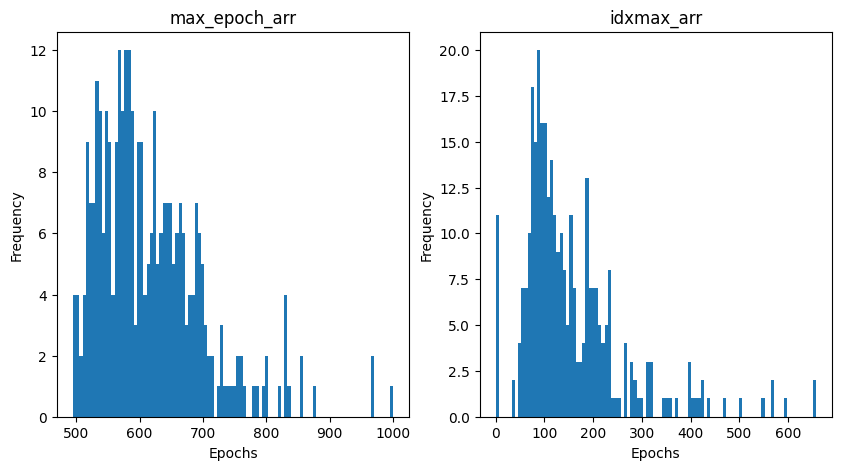

In [12]:
from scripts.result_analysis.model_analysis import model_result
import os
import pandas as pd
import matplotlib.pyplot as plt




show_max_epoch_idxmax(main_path = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_')



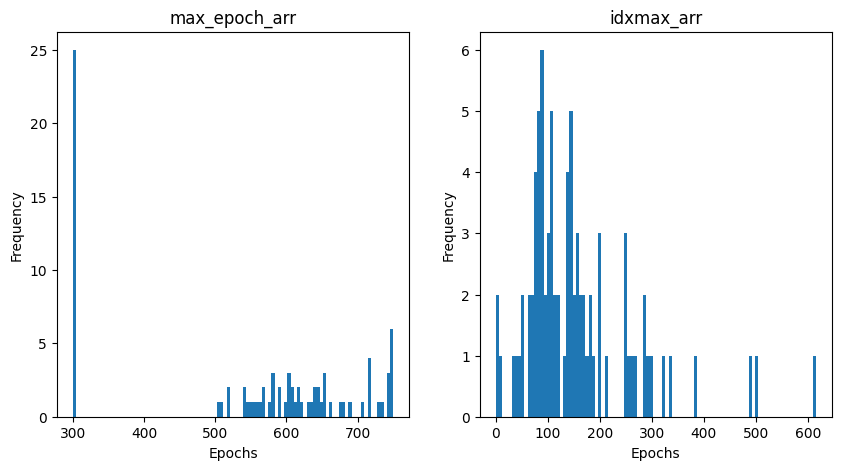

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

max_epoch_arr = []
idxmax_arr = []

main_path = 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_'

TOTAL_SUBJECT = 64
NUM_OF_K_FOLD = 5 
history_file_name = 'history.csv'
best_model_based_metric = 'val_accuracy'
inner_fold_name = 'stratified_nested_5_CV_fold-'

for sub in range(TOTAL_SUBJECT):
    for k in range(NUM_OF_K_FOLD):
        fold_path = main_path + str(sub) + '/' + inner_fold_name + str(k)
        file_path = fold_path + '/' + history_file_name
        if os.path.exists(file_path):
            res = pd.read_csv(file_path)
            max_index = len(res[best_model_based_metric]) # 
            indx_max = res[best_model_based_metric].idxmax()
            max_epoch_arr.append(max_index)
            idxmax_arr.append(indx_max)
            
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(max_epoch_arr, bins=100)
axs[0].set_title('max_epoch_arr')
axs[1].hist(idxmax_arr, bins=100)
axs[1].set_title('idxmax_arr')
for i in range(2):
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Frequency')

In [2]:
import numpy as np
merge_psychiatry_demo = np.load('allData/prognosis_mix_hb/pretreatment_response/merge_psychiatry_demo_dose_data.npy')
print(merge_psychiatry_demo.shape)
x2 = np.load('allData/prognosis_mix_hb/pretreatment_response/nor_demo_cli_merge_data.npy')
print(x2.shape)

(64, 10)
(64, 17)


: 

In [2]:
# calculate feature and apply SVM/XGBoost to see the performance

# 1. load the data
input_fold = 'allData/prognosis_mix_hb/pretreatment_response'
data = np.load(input_fold + '/hb_data.npy')
label = np.load(input_fold + '/label.npy')

print(data.shape)
HbO = data[...,0::2] # np.transpose(data[...,0::2],(0,2,1))
# HbO = individual_normalization(HbO)
print(f'HbO: {HbO.shape}')
HbR = data[...,1::2] # np.transpose(data[...,1::2],(0,2,1))
HbT = HbO + HbR

data = np.concatenate((HbO,HbR,HbT),axis=-1)


(64, 52, 2500)
HbO: (64, 52, 1250)


configs/pretreatment_response_cv_5_hbo.py

python ./LOO_nested_CV_train.py cnn_gnn_transformer loocv_v0 pretreatment_response_cv_5_hbo

In [9]:
for i in range(20):
    command = f'python scripts/plot/DL/read_LOO_nestedCV_gnntr.py --max 4 --K_FOLD 5 --result_path results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v{i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6'.split(' ')
    result = subprocess.run(command, capture_output=True, text=True)
    print(command)
    print(result.stdout)

['python', 'scripts/plot/DL/read_LOO_nestedCV_gnntr.py', '--max', '4', '--K_FOLD', '5', '--result_path', 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6']
val_fold_path results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_0
num_of_cv_folds 5
y_test [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
MAX_ITR: 4 ranging ( 2 ~ 3 )
Model name: gnn_transformer_with_cli_demo
specify_itr None
value_add_to_sensitivity_value 0.0
| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|----

In [7]:
command

['python',
 'scripts/plot/DL/read_LOO_nestedCV_gnntr.py',
 '--max',
 '4',
 '--K_FOLD',
 '5',
 '--result_path',
 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6']

In [8]:
import numpy as np
# y_pred_all = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten-fold-evaluate/y_pred_test_all.npy')
y_pred_all = np.load('results/gnn_transformer_with_cli_demo_v1/prognosis_mix_hb/pretreatment_response/ten-fold-evaluate/y_pred_test_all.npy')

print(y_pred_all.shape)
np.save('allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy', y_pred_all)

(10, 64, 2)


: 

In [ ]:
import numpy as np
print(y_pred_all.shape)
np.save('allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy', y_pred_all)

In [60]:
a = [0,1,1,0,0,0,1]
a_one_hot = tf.one_hot(a, 2)

freq_accumulator = tf.reduce_sum(a_one_hot, axis=0, keepdims=True)
freq_comparator = tf.tile(freq_accumulator, [2, 1])
print('freq_accumulator', freq_accumulator)
print('transpose freq_accumulator', tf.transpose(freq_accumulator))
print('freq_comparator', freq_comparator)
mask = tf.cast(
            tf.greater(tf.transpose(freq_accumulator), freq_comparator),
            dtype=tf.float32,
        )

freq_accumulator tf.Tensor([[4. 3.]], shape=(1, 2), dtype=float32)
transpose freq_accumulator tf.Tensor(
[[4.]
 [3.]], shape=(2, 1), dtype=float32)
freq_comparator tf.Tensor(
[[4. 3.]
 [4. 3.]], shape=(2, 2), dtype=float32)


In [61]:
long_tail = freq_comparator / tf.transpose(freq_accumulator)
p_factor = 0.8
mitigator = (long_tail ** p_factor) * mask + (1-mask)
mitigator_factor = tf.gather(mitigator, tf.argmax(a_one_hot, axis=-1))
mitigator_factor

<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
array([[1.        , 0.79441786],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 0.79441786],
       [1.        , 0.79441786],
       [1.        , 0.79441786],
       [1.        , 1.        ]], dtype=float32)>

In [58]:
# _get_compensation_factor

q_factor = 2.0

labels = a_one_hot

logits = tf.constant([[0.56, 0.44], [0.6, 0.4], [0.45, 0.55], [0.66, 0.34], [0.7, 0.3], [0.1, 0.9], [0.45, 0.55]])

scores = tf.math.softmax(logits, axis=-1)

gt_label = tf.argmax(labels, axis=1)

indices = tf.stack(
            [tf.range(0, tf.shape(logits)[0], dtype=gt_label.dtype), gt_label], axis=1
        )

cls_score = tf.gather_nd(scores, indices)
argmax_logits = tf.argmax(logits, axis=-1) == gt_label
compensator = scores / tf.expand_dims(cls_score, axis=-1)
mask = tf.cast(tf.greater(compensator, 1.0), dtype=labels.dtype)
compensation_factor = (compensator ** q_factor) * mask + (1 - mask)
print('compensation_factor', compensation_factor)

compensation_factor tf.Tensor(
[[1.        1.       ]
 [1.4918244 1.       ]
 [1.        1.       ]
 [1.        1.       ]
 [1.        1.       ]
 [1.        4.9530325]
 [1.        1.       ]], shape=(7, 2), dtype=float32)


In [62]:
seesaw_weights = tf.ones_like(labels, dtype=tf.float32)
seesaw_weights *= mitigator_factor 
seesaw_weights = seesaw_weights * compensation_factor
print('seesaw_weights', seesaw_weights)


seesaw_weights tf.Tensor(
[[1.         0.79441786]
 [1.4918244  1.        ]
 [1.         1.        ]
 [1.         0.79441786]
 [1.         0.79441786]
 [1.         3.9347775 ]
 [1.         1.        ]], shape=(7, 2), dtype=float32)


In [67]:
print(seesaw_weights)
print(1-labels)
print((1-labels) * seesaw_weights)

tf.Tensor(
[[1.         0.79441786]
 [1.4918244  1.        ]
 [1.         1.        ]
 [1.         0.79441786]
 [1.         0.79441786]
 [1.         3.9347775 ]
 [1.         1.        ]], shape=(7, 2), dtype=float32)
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(7, 2), dtype=float32)
tf.Tensor(
[[0.         0.79441786]
 [1.4918244  0.        ]
 [1.         0.        ]
 [0.         0.79441786]
 [0.         0.79441786]
 [0.         3.9347775 ]
 [1.         0.        ]], shape=(7, 2), dtype=float32)


: 

In [4]:
data = np.load('allData/prognosis/pretreatment_response/hb_data.npy')
data.shape

(64, 52, 2500)

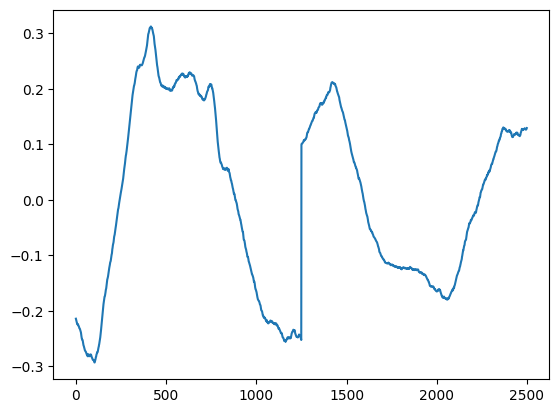

In [5]:
plt.plot(np.mean(data, axis=(0, 1)))

In [7]:
a = np.arange(10)

shuffled_indices = np.random.permutation(a.shape[0])
print(shuffled_indices)

original = [shuffled_indices.tolist().index(i) for i in range(10)]
shuffle_back = shuffled_indices[original]

print(shuffle_back)

[3 4 6 0 9 7 5 1 2 8]
[0 1 2 3 4 5 6 7 8 9]


In [3]:
data = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/his_metrics.npy', allow_pickle=True)
print(data)

{'fprs': [array([0.  , 0.02, 0.04, 0.08, 0.14, 0.18, 0.18, 0.18, 0.22, 0.28, 0.36,
       0.4 , 0.4 , 0.44, 0.44, 0.5 , 0.5 , 0.52, 0.6 , 0.62, 0.7 , 0.7 ,
       0.72, 0.72, 0.74, 0.74, 0.84, 0.92, 0.96, 0.96, 1.  ]), array([0.  , 0.02, 0.08, 0.08, 0.14, 0.14, 0.34, 0.34, 0.36, 0.36, 0.38,
       0.38, 0.4 , 0.4 , 0.48, 0.48, 0.54, 0.54, 0.64, 0.64, 0.7 , 0.74,
       0.82, 0.82, 0.84, 0.84, 1.  ]), array([0.  , 0.04, 0.68, 0.68, 0.68, 0.68, 0.68, 0.76, 0.82, 0.82, 1.  ]), array([0.  , 0.02, 0.06, 0.1 , 0.14, 0.28, 0.32, 0.36, 0.44, 0.48, 0.48,
       0.5 , 0.54, 0.62, 0.68, 0.68, 0.7 , 0.74, 0.78, 0.9 , 0.9 , 0.96,
       1.  ]), array([0.  , 0.02, 0.12, 0.16, 0.24, 0.24, 0.26, 0.3 , 0.36, 0.36, 0.4 ,
       0.4 , 0.46, 0.46, 0.48, 0.48, 0.52, 0.52, 0.56, 0.58, 0.58, 0.62,
       0.64, 0.68, 0.68, 0.78, 0.82, 0.88, 0.88, 0.92, 0.96, 1.  ]), array([0.  , 0.02, 0.14, 0.14, 0.28, 0.28, 0.36, 0.38, 0.38, 0.42, 0.42,
       0.48, 0.48, 0.5 , 0.5 , 0.52, 0.52, 0.54, 0.54, 0.58, 0.58, 0.6 ,

In [4]:
a = np.ones((4,4))
for i in range(4):
    a[:,i] *= i
    
a[2, :] *= 5
print(a)
a[:,1] = (a[:, 2] + a[:, 3]) / 2
print(a)

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  5. 10. 15.]
 [ 0.  1.  2.  3.]]
[[ 0.   2.5  2.   3. ]
 [ 0.   2.5  2.   3. ]
 [ 0.  12.5 10.  15. ]
 [ 0.   2.5  2.   3. ]]


In [2]:
result = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/y_pred.npy')
print('loocv4 - ', result.shape)

loocv4 -  (320, 2)


In [3]:
allData_loocv4 = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis_mix_hb/pretreatment_response/fnirs_pred_loocv4.npy')
print('allData_loocv4 - ', allData_loocv4.shape)

allData_loocv4 -  (320, 2)
